# Quickstart
This module will help you get started in DPIV processing.

Prerequisites
=============

You'll need to know a little bit of Python. 

To work the examples, you will need ``numpy``, ``imageio``, ``scipy``, and ``matplotlib`` installed
in addition to this package.

Load images
===========

There are several way to load images, however the one we would be using is the image loader from our package.

In [1]:
import openpiv_cxx
from openpiv_cxx.tools import imread

Data processing is generally done in double precision, 64-bit arrays, with the exception of image filters. To ensure the correct data type, it is best to import float64 from numpy.

In [2]:
import numpy as np
Float = np.float64

Now, we can load some images. For simplicity, we are loading images relative to this notebook. The images are from PIV Challenge 2014 case A as it requires significant image preprocessing. You can download the full data set here: https://www.pivchallenge.org/pivchallenge4.html

In [3]:
frame_a = imread("images/A_00001_a.TIF").astype(Float, copy=False)
frame_b = imread("images/A_00001_b.TIF").astype(Float, copy=False)

When preprocessing, it is import to compress the image to [-1..1]. Here, we assume that if there are any negative pixel intensities, their absolute value is smaller than the largest positive pixel intensity.

In [4]:
max_a = frame_a.max()
max_b = frame_b.max()

frame_a /= max_a
frame_b /= max_b

Now. we can plot our image.

In [5]:
from matplotlib import pyplot as plt

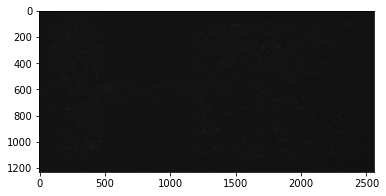

In [6]:
_ = plt.imshow(frame_a, vmin=0, vmax=1, cmap="gray")

As we see, the image intensities are quite low. However, the image quality can be better assessed by lowering vmax.

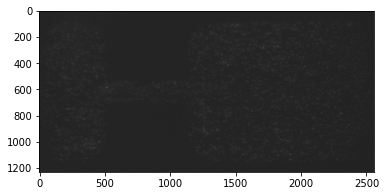

In [7]:
_ = plt.imshow(frame_a, vmin=0, vmax=0.5, cmap="gray")

The first thing we want to do is to perform contrast stretching. It doesn't have to be done first during the entire procedure, but it can be useful to assess what to do next.

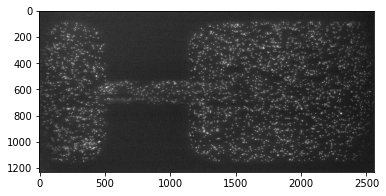

In [8]:
from openpiv_cxx import filters

new_img = frame_a.copy()
new_img = filters.contrast_stretch(new_img, 0.3, 99.8)

_ = plt.imshow(new_img, vmin=0, vmax=1, cmap="gray")

Nice! The image quality has gone up, but so has the noise. To supress noise, median filtering (not implemented yet!) is generally needed as high pass filtering is not enough (loses too much contrast with this image pair). Since someone forgot to implement a median filter, we would use SciPy's version for now.

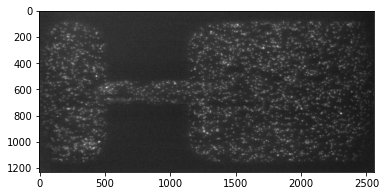

In [9]:
from scipy.ndimage import median_filter

new_img = median_filter(new_img, size = 7)

_ = plt.imshow(new_img, vmin=0, vmax=1, cmap="gray")

Not great, but lets try a different order of filters.

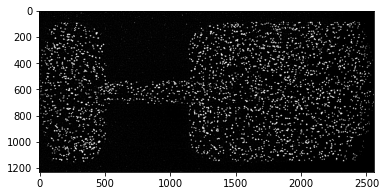

In [10]:
new_img = frame_a.copy()

new_img = median_filter(new_img, size = 7)
new_img = filters.contrast_stretch(new_img, 20, 99)
new_img = filters.highpass_filter(new_img, sigma = 5, clip_at_zero=True)
new_img[new_img > 0.1] = 1

_ = plt.imshow(new_img, vmin=0, vmax=1, cmap="gray")

Now that we played around with the parameters of different filters, we got a decent quality image to perform DPIV. Images that contain high contrast of particles with said particles approximating a gaussian profile typically produce the lowest amount of uncertainty. Since these particles retained some resemblance of a gaussian profile, gaussian filtering is not needed. So, we can go ahead and pre-process our images.

In [11]:
frame_a = median_filter(frame_a, size = 7)
frame_a = filters.contrast_stretch(frame_a, 20, 99)
frame_a = filters.highpass_filter(frame_a, sigma = 5, clip_at_zero = True)
frame_a[frame_a > 0.1] = 1

frame_b = median_filter(frame_b, size = 7)
frame_b = filters.contrast_stretch(frame_b, 20, 99)
frame_b = filters.highpass_filter(frame_b, sigma = 5, clip_at_zero = True)
frame_b[frame_b > 0.1] = 1

frame_a *= 2**12 - 1 # resize to 12 bit float
frame_b *= 2**12 - 1

Now that we are ready for DPIV processing, we are going to select a relatively large interrogation window so that all velocity components can be estimated.

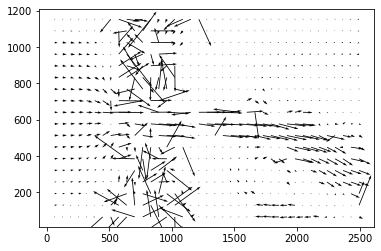

In [12]:
from openpiv_cxx import windef as piv_prc

x, y, u, v, s2n = piv_prc.first_pass(
    frame_a,
    frame_b,
    window_size = 128,
    overlap = 64,
    correlation_method = "linear" # more robust but much slower
)

_ = plt.quiver(x,y,u,v)

As we see, most of the correlations are successful minus some outliers. We can remove them with outlier detection and replacement functions.

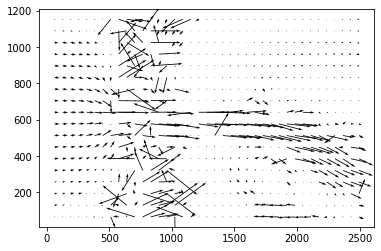

In [13]:
from openpiv_cxx import validate
from openpiv_cxx.inpaint_nans import replace_outliers

u, v, _ = validate.global_std(u, v, std_threshold = 3)
u, v = replace_outliers(u, v, kernel_size = 2, method = "localmean")

_ = plt.quiver(x,y,u,v)

Since there are numerous outliers due to the nature of this image pair, we could smooth the vector field to diminish their effect on any further processing.

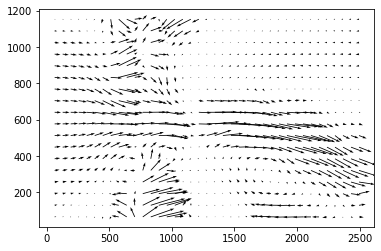

In [14]:
from openpiv_cxx.smooth import smoothn # requires scipy

u, _, _, _ = smoothn(u, s=0.8)
v, _, _, _ = smoothn(v, s=0.8)

_ = plt.quiver(x,y,u,v)

Conclusions
===========

We loaded, pre-processed, analyzed, and post-processed an image pair. A simple processing workflow was created that could be easily modified for the analysis of different DPIV images. More examples are currently in progress.